<a href="https://colab.research.google.com/github/3791xk/Git-Exam-Source/blob/main/PAM_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Advanced Objective Function and Use Case
## Part 1
For Logistic Regression, we’re starting with the sigmoid function we want to minimize:

$ σ(z)= \frac {1} {(1 + e^{-z})} $

Where $z$ is the sum of the input paramteres for each feature:

$ z = w_0x_0 + w_1x_1 + ... + w_nx_n  $

Which we can rewrite as:

$ z = \sum_{i=1}^n w_ix_i = w^Tx$

This is also the conditional probability of observing $x$ given a value for $y$:

$ z = p(y | x) = \text{log}(\frac {p(y|x)}{1-p(y|x)}) $

$
    y=
\begin{cases}
    1,& \text{if } σ(x)\geq 0.5\\
    0,              & \text{otherwise}
\end{cases}
\
$

To use Maximum Likelihood Estimation (MLE), we need to write a function for the likelihood:

$ L(w) = P(y|x) = Π_{i=1}^np(y^{(i)}|x^{(i)}) = Π_{i=1}^n(σ(z^{(i)})^{y^{(i)}})(1-σ(z^{(i)})^{1-y^{(i)}})$

We then take the natural log of the equation so it is easier to maximize, getting the log-likelihood function:

$ l(w) = \text{log} L(w) = \Sigma _{i=1}^ny^{(i)}\text{log}(\sigma(z^{(i)}))+(1-y^{(i)})\text{log}(1-σ(z^{(i)}))$

Thus we have found an objective function for Logistic Regression.
## MAP vs MLE
Maximum a Posteriori Estimation (MAP) is an alternative technique to MLE for regression problems. MLE tends to overfit by reshaping the function so that it passes through precise data points, but ends up having higher variance and being less generalizeable. However MAP limits the impact of large parameter values by placing a preselected distribution on each of the model's parameters. This technique also helps regularize the loss function.

### Sources:

[LogisticRegression: A binary classifier](https://rasbt.github.io/mlxtend/user_guide/classifier/LogisticRegression/#logisticregression-a-binary-classifier)

[The Ultimate Guide for Linear Regression Theory](https://medium.com/@luckecianomelo/the-ultimate-guide-for-linear-regression-theory-918fe1acb380)

## Part 2

A machine learning problem I would like to solve using Logistic Regression is whether a registered attendee for a hackathon will actually attend the event. Logistic regression is the best choice for this, as attendance is a binary outcome (yes if they check in day-of, no if they don't). Features like the attendee's university could be very useful as students are significantly more likely to attend a hackathon if they attend the school that the hackathon is hosted at. Features like grade level are also likely to. This model is also relatively straightforward and interpretable, so the hackathon organizers could apply what they learn from the trained model's weights to who they especially need to target with advertising.

Using a different linear classification model, like a least square linear regression would be less effective as it could give predicted values outside the 0-1 range. The continous nature of the output values would be unecessary, and the straight line may not be the best fit for the data.

### Source:
[Paper 2 from Lecture 1 Reading](https://www.nottingham.ac.uk/mathematics/documents/pgt-course-resources/linear-models.pdf)


## Part 3
The hackathon registration dataset has feature vectors $x$ for each column of information like gender, number of hackathons attended, school year, etc. Columns like gender or university are categorical values, while number of hackathons attended or years of coding experience would be numerical. We are making the assumption in our derivation that the features are independent of each other, so it would be important not to include potentially conflicting values like both school year and age. Our target labels $y$ would be the result of whether or not that registrant checked in on the day of the event expressed as $1$ for attending and $0$ for not. After creating the model, the weights $w$ would correspond to the importance of different features in the prediction calculation.


# Task 2: Dataset and Advanced EDA
## Part 1

In [1]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kagglehub
import tensorflow as tf
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import Normalizer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Dataset: Bird Bones and Living Habits
# https://www.kaggle.com/datasets/zhangjuefei/birds-bones-and-living-habits/data

df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, 'zhangjuefei/birds-bones-and-living-habits/versions/1', 'bird.csv')
df.head()

100%|██████████| 24.9k/24.9k [00:00<00:00, 26.5MB/s]


,id,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type
0,0,80.78,6.68,72.01,4.88,41.81,3.70,5.50,4.03,38.70,3.84,SW
1,1,88.91,6.63,80.53,5.59,47.04,4.30,80.22,4.51,41.50,4.01,SW
2,2,79.97,6.37,69.26,5.28,43.07,3.90,75.35,4.04,38.31,3.34,SW
3,3,77.65,5.70,65.76,4.77,40.04,3.52,69.17,3.40,35.78,3.41,SW
4,4,62.80,4.84,52.09,3.73,33.95,2.72,56.27,2.96,31.88,3.13,SW


In [6]:
# Confirm more than 10 features
df.shape

(420, 12)

In [247]:
# value counts for type
  # SW: Swimming Birds
  # W: Wading Birds
  # T: Terrestrial Birds
  # R: Raptors
  # P: Scansorial Birds
  # SO: Singing Birds

df.type.value_counts()

,count
type,
SO,128
SW,116
W,65
R,50
P,38
T,23


## Part 2 + Part 3

As we can tell from both the pairwise relationships in the dataset, and the features correlation seen below, the measurements in this data are highly correlated with each other and not necessarily independent. For example, there are five types of bones measured for these birds, and for each bone we have both its length and the diameter. A bird with one large bone measurement is very likely larger and more likely to have other large bone measurements. I am not convinced you could really call these multicollinear, as the correlations between bones is likely not independent.

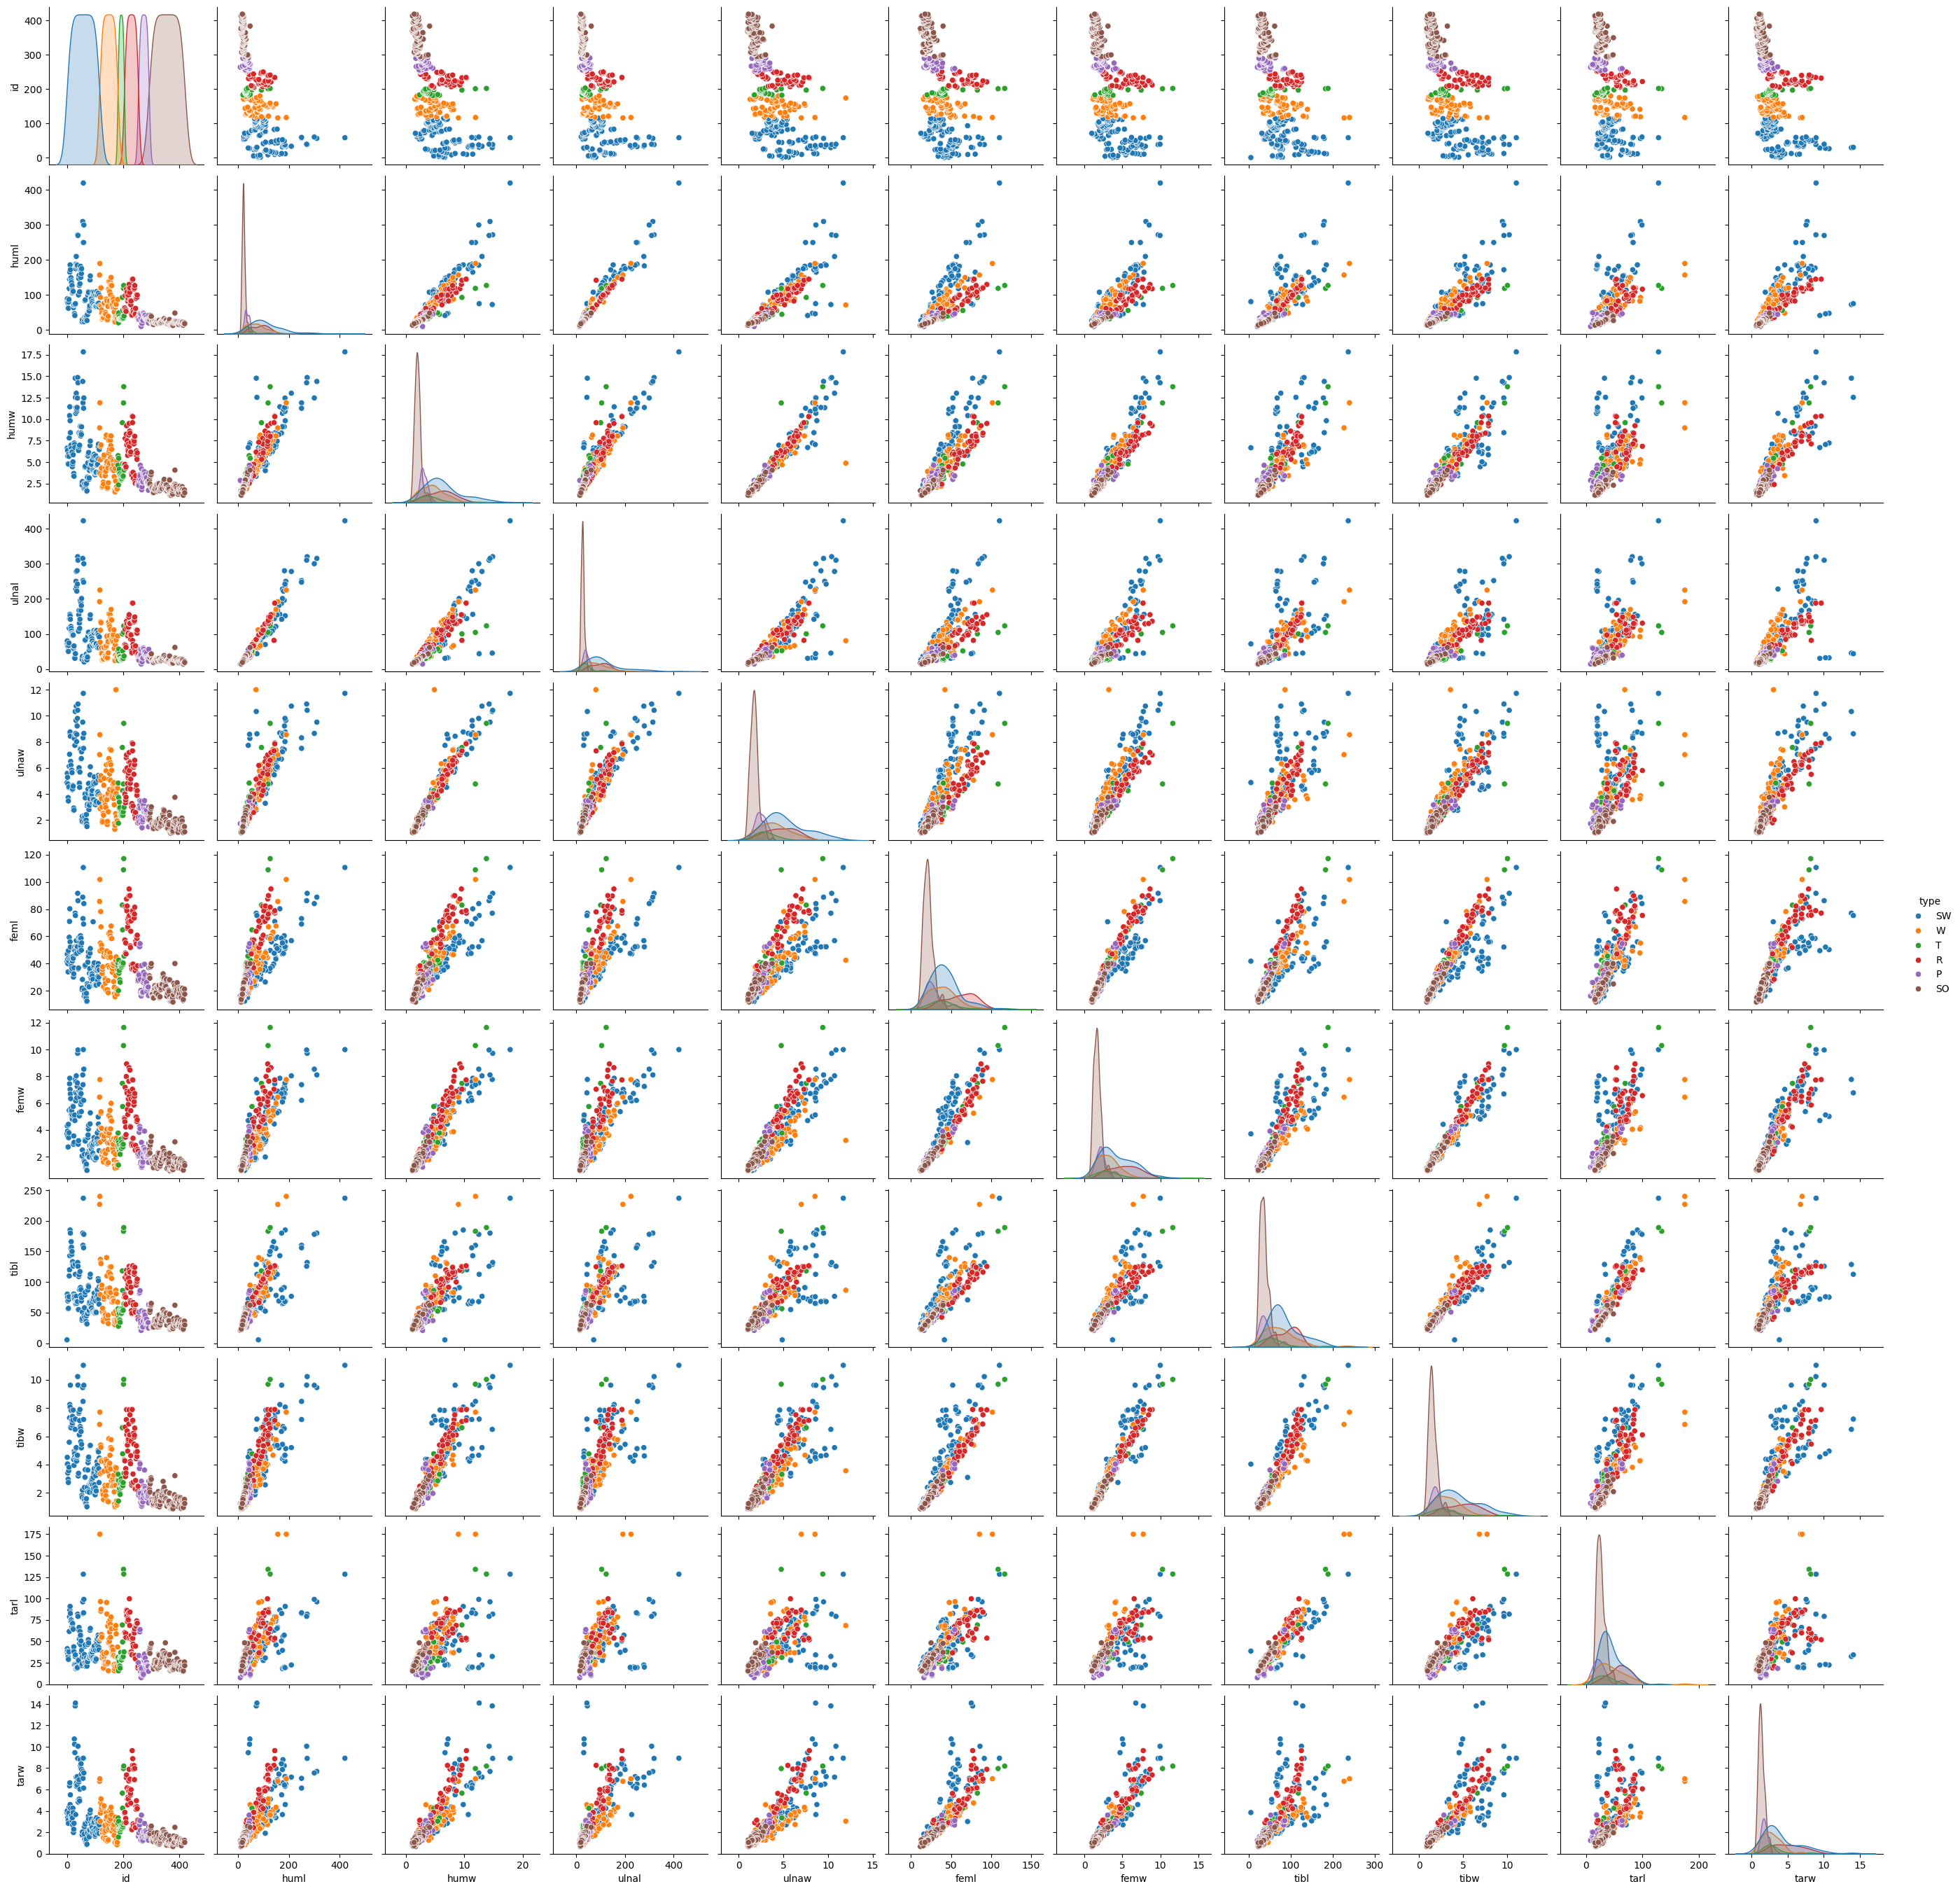

In [248]:
# Pair plot w/ KDE for pairwise relationships

sns.pairplot(df, hue='type', diag_kind='kde')

<Axes: >

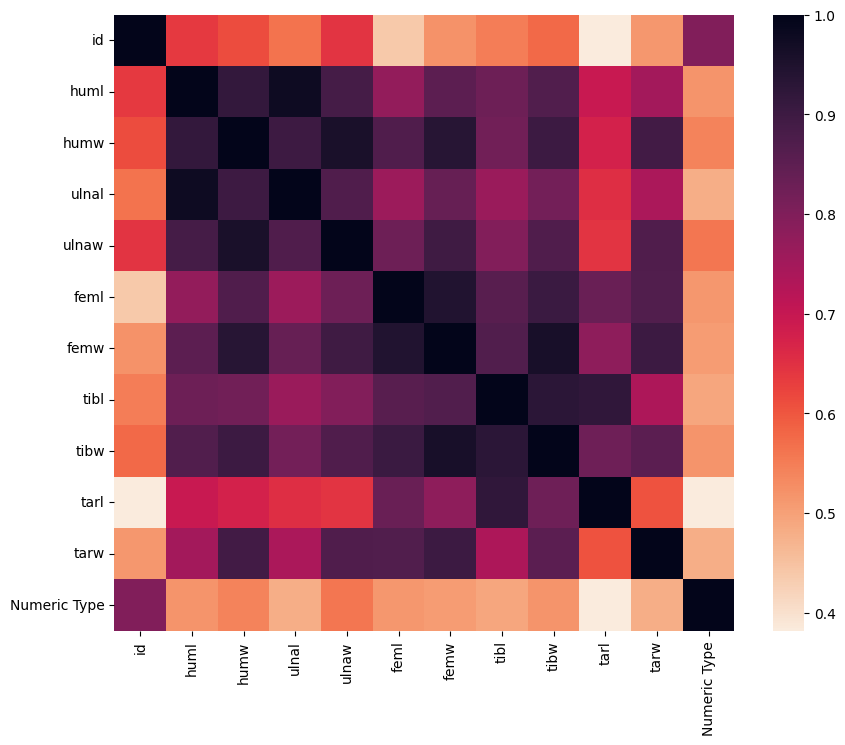

In [7]:
# Features Correlation

# Mapping type of bird to 0 or 1 based on whether they'rte songbirds
mapping = {'SW': 0, 'SO': 1, 'W': 0, "P": 0, "R": 0, "T": 0}
df['Numeric Type'] = df['type'].map(mapping)

fig, ax = plt.subplots(figsize=(10,8))
num_df = df.select_dtypes(include=['number'])
sns.heatmap(num_df.corr().abs(),annot=False, ax=ax, cmap='rocket_r')

In [8]:
# Check for amount of null and/or incomplete data
df.isna().sum()

,0
id,0
huml,1
humw,1
ulnal,3
ulnaw,2
feml,2
femw,1
tibl,2
tibw,1
tarl,1


In [251]:
# value counts for type
# numbers in paranthesis are arbitrarily assigned to each type for numerical plotting
  # SW: Swimming Birds (1)
  # W: Wading Birds (3)
  # T: Terrestrial Birds (6)
  # R: Raptors (5)
  # P: Scansorial Birds (4)
  # SO: Singing Birds (2)

# Number of samples of each type
print(df.type.value_counts())

# Average + Standard Deviation of measurements for each bird type, by bone
average_by_type = df.groupby('type').agg(['mean', 'std'])
print(average_by_type)

type
SO    128
SW    116
W      65
R      50
P      38
T      23
Name: count, dtype: int64
         id                   huml                 humw                 ulnal  \
       mean        std        mean        std      mean       std        mean   
type                                                                            
P     272.5  11.113055   34.423947   9.399708  3.039211  0.631918   39.177368   
R     228.5  14.577380   86.934400  31.715294  6.065600  2.170025  100.342449   
SO    355.5  37.094474   22.361102   6.111564  2.029764  0.550998   26.398095   
SW     57.5  33.630343  110.251121  66.225024  6.423966  3.283262  111.755517   
T     192.0   6.782330   45.699565  28.068796  4.786087  2.944815   45.617391   
W     148.0  18.907670   73.133077  37.842339  4.607077  2.122710   78.101385   

                    ulnaw            ...       tibl                 tibw  \
            std      mean       std  ...       mean        std      mean   
type                       

In [252]:
# the independent variables set
vif_df = df.drop(columns=['type'])
vif_df = vif_df.dropna()
vif_df.insert(0, 'Intercept', 1)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = vif_df.columns
vif_data['VIF'] = [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]

# Drop the intercept row for interpretation
vif_data = vif_data[vif_data['Feature'] != 'Intercept']
print(vif_data)

         Feature        VIF
1             id   5.050889
2           huml  68.408792
3           humw  30.058935
4          ulnal  45.448947
5          ulnaw  13.874394
6           feml  20.011769
7           femw  45.174851
8           tibl  23.069384
9           tibw  36.643945
10          tarl  13.909308
11          tarw   9.015350
12  Numeric Type   3.681969


After using the Variance Inflation factor, we can see that the VIF scores are insanely high for most of these features as size of bird is generally correlated with size of bird. So instead, we'll be exploring whether it is possible to identify the ecological group a bird is in based on the ratio between length and diameter of each bone. We can see significantly lower VIF scores now as well and reduce the amount of direct correlation.

In [9]:
# Change features to ratios between length and diameter of each bone
ratio_df = df.drop(columns=['type'])
ratio_df = ratio_df.dropna()
ratio_df['HumerusRatio'] = df['huml'] / df['humw']
ratio_df['UlnaRatio'] = df['ulnal'] / df['ulnaw']
ratio_df['FemurRatio'] = df['feml'] / df['femw']
ratio_df['TibiotarsusRatio'] = df['tibl'] / df['tibw']
ratio_df['TarsometatarsusRatio'] = df['tarl'] / df['tarw']

ratio_df = ratio_df.drop(columns=['huml', 'humw', 'ulnal', 'ulnaw', 'feml', 'femw', 'tibl', 'tibw', 'tarl', 'tarw'])
print(ratio_df.head())

   id  Numeric Type  HumerusRatio  UlnaRatio  FemurRatio  TibiotarsusRatio  \
0   0             0     12.092814  14.756148   11.300000          1.364764   
1   1             0     13.410256  14.406082   10.939535         17.787140   
2   2             0     12.554160  13.117424   11.043590         18.650990   
3   3             0     13.622807  13.786164   11.375000         20.344118   
4   4             0     12.975207  13.965147   12.481618         19.010135   

   TarsometatarsusRatio  
0             10.078125  
1             10.349127  
2             11.470060  
3             10.492669  
4             10.185304  


In [254]:
# trying VIF again
vif_df = ratio_df.dropna()
vif_df.insert(0, 'Intercept', 1)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = vif_df.columns
vif_data['VIF'] = [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]

# Drop the intercept row for interpretation
vif_data = vif_data[vif_data['Feature'] != 'Intercept']
print(vif_data)

                Feature       VIF
1                    id  4.598073
2          Numeric Type  3.228339
3          HumerusRatio  4.506450
4             UlnaRatio  2.894858
5            FemurRatio  1.759411
6      TibiotarsusRatio  2.613682
7  TarsometatarsusRatio  2.673679


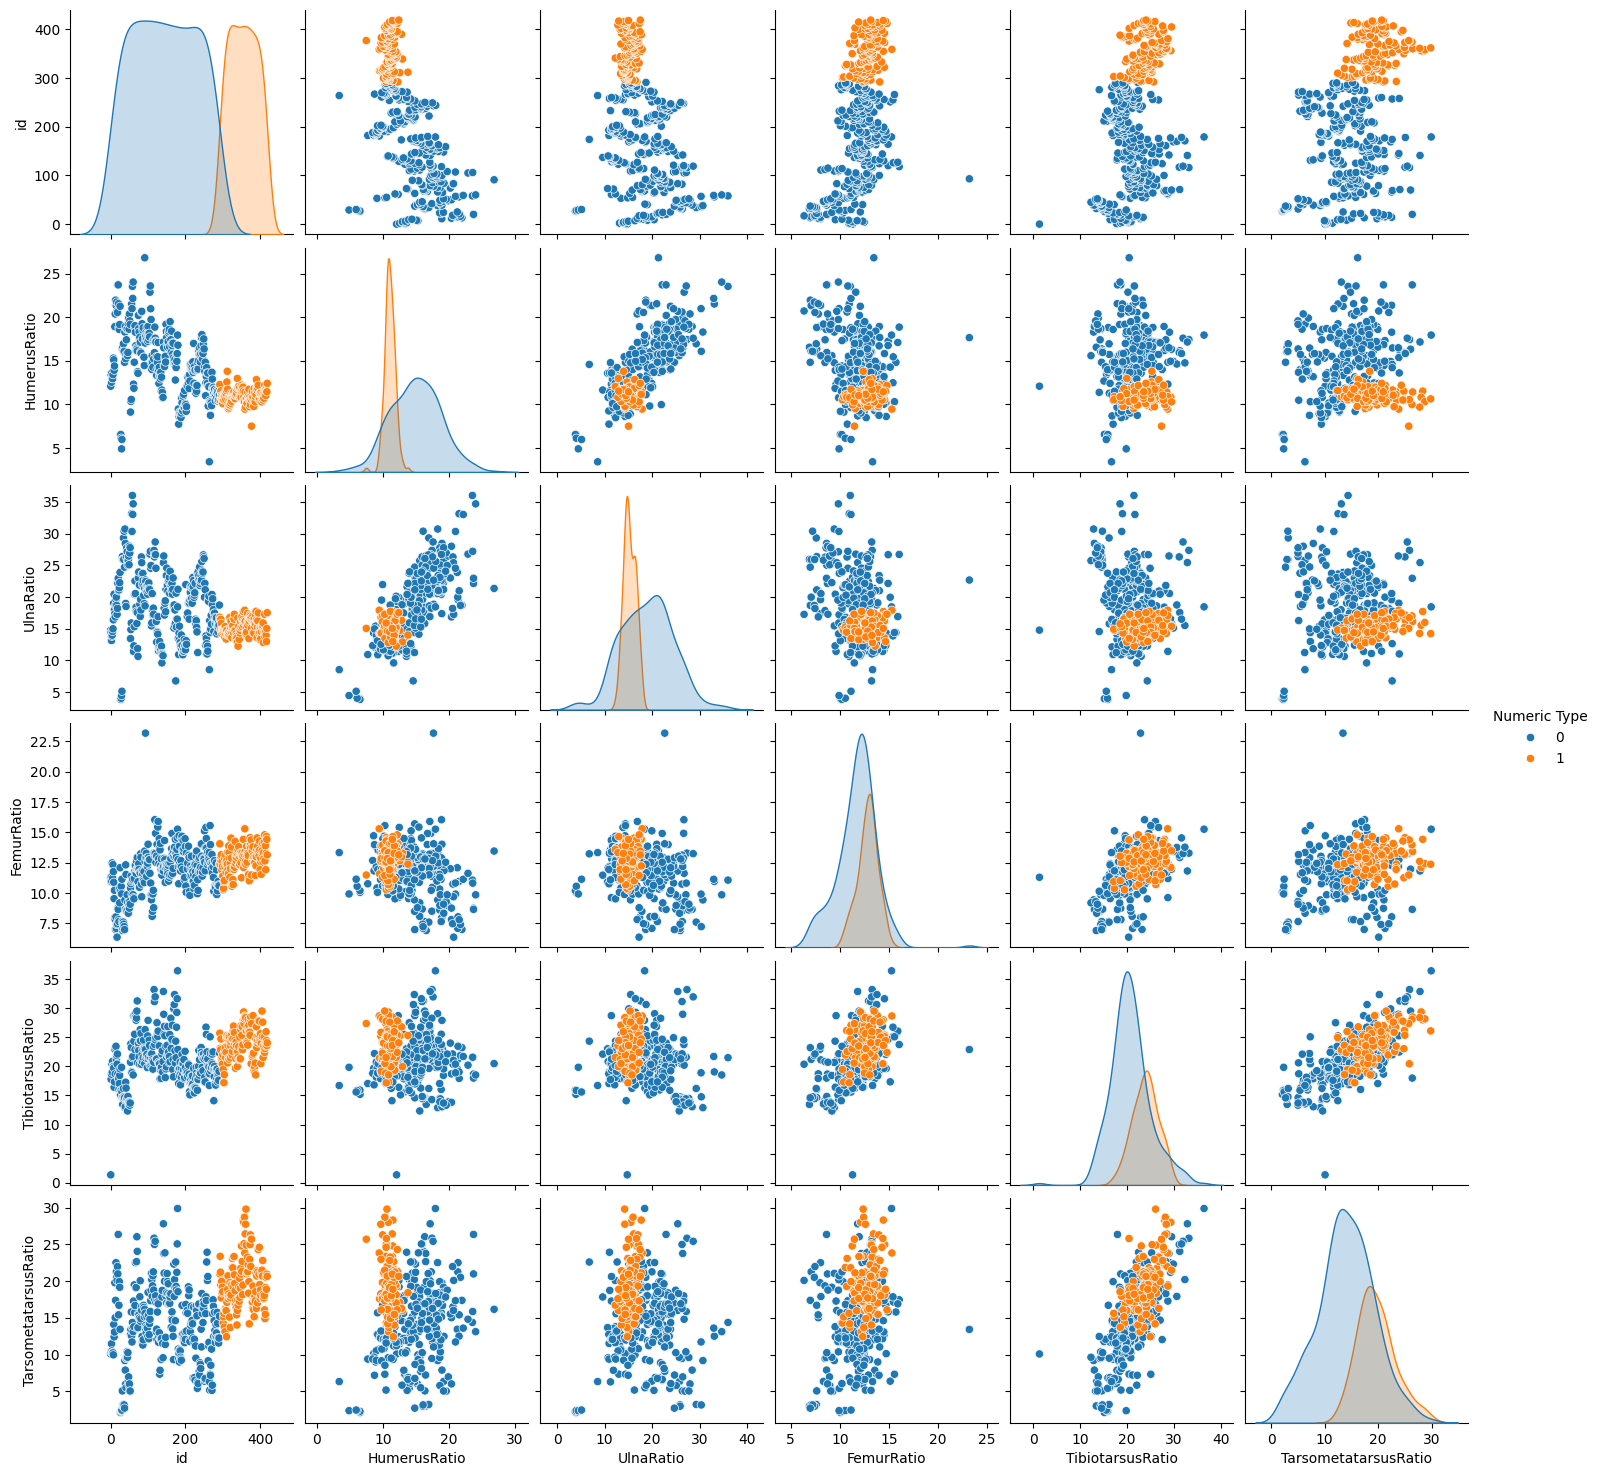

In [255]:
# New pair plot with KDE check
sns.pairplot(ratio_df, hue='Numeric Type', diag_kind='kde')

<Axes: >

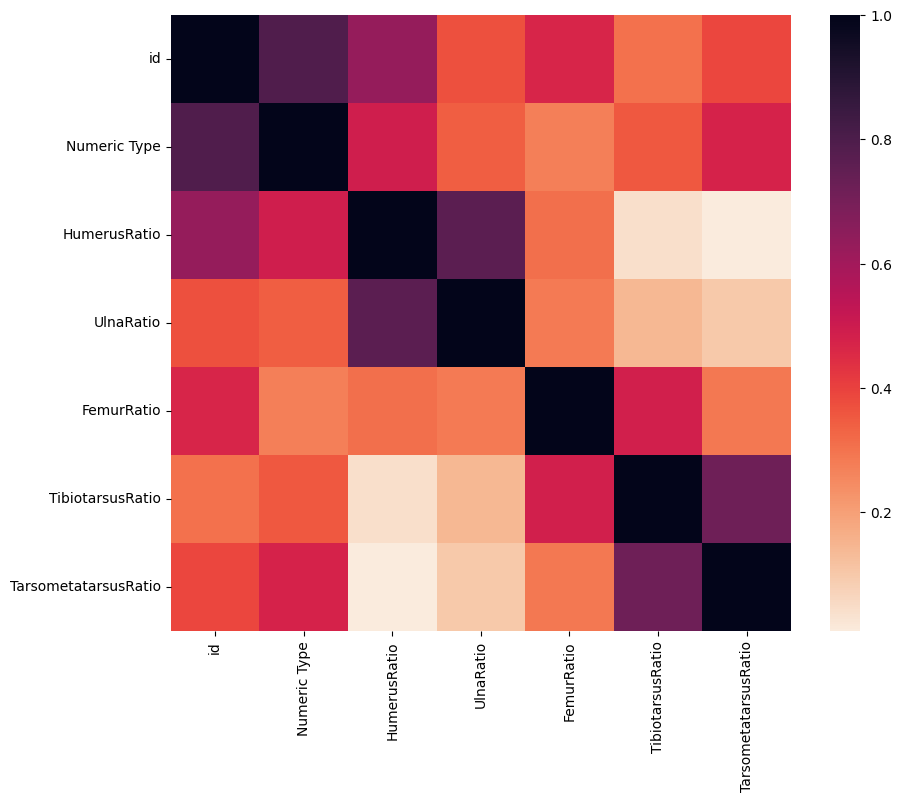

In [256]:
# New heatmap check
fig, ax = plt.subplots(figsize=(10,8))
num_df = ratio_df.select_dtypes(include=['number'])
sns.heatmap(num_df.corr().abs(),annot=False, ax=ax, cmap='rocket_r')

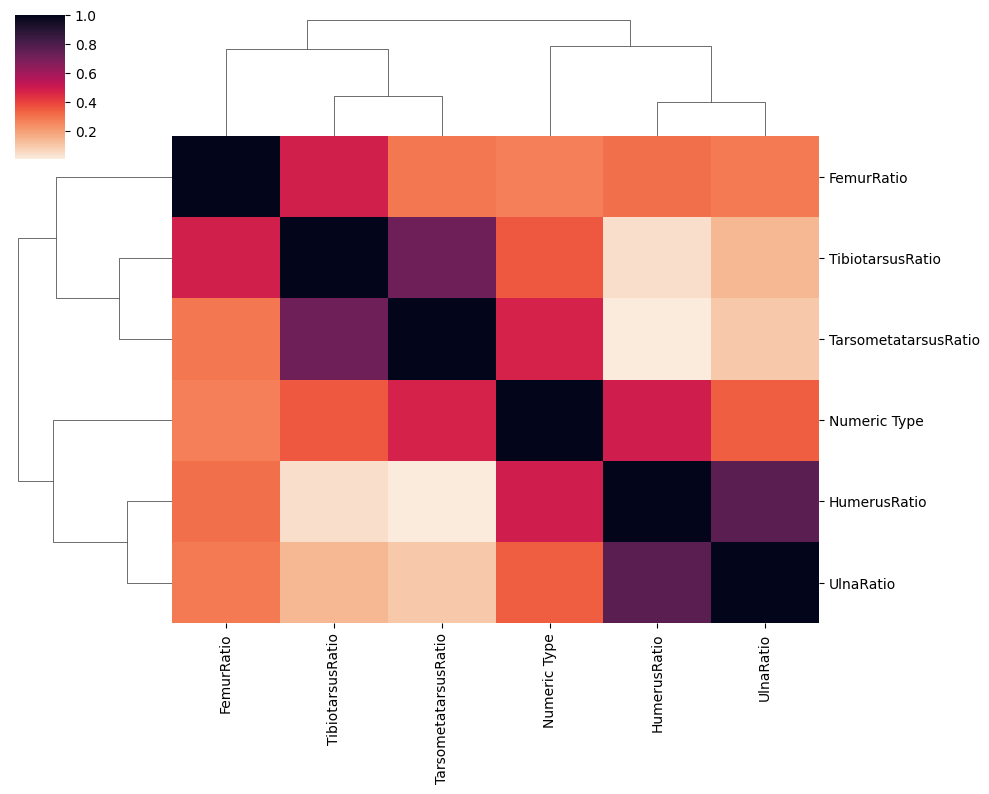

In [257]:
# Heatmap with clustering

heatmap_df = ratio_df.drop(columns=['id'])
sns.clustermap(heatmap_df.corr().abs(), cmap='rocket_r', annot=False, figsize=(10,8))
plt.show()

# Task 3: Logistic Regression Implementation
## Part 1

For this task, logistic regression is being used on the Bird Bones dataset to determine whether a given bird is in the ecological category of Songbird or not based on the ratio between the length and diameter of a certain bones. I selected Songbirds because they represent a statistically significant percent of the overall data and appear relatively distinct the graphs like the pairplots.

In [52]:
ratio_df.head()

,id,Type,HumerusRatio,UlnaRatio,FemurRatio,TibiotarsusRatio,TarsometatarsusRatio
0,0,0,12.092814,14.756148,11.300000,1.364764,10.078125
1,1,0,13.410256,14.406082,10.939535,17.787140,10.349127
2,2,0,12.554160,13.117424,11.043590,18.650990,11.470060
3,3,0,13.622807,13.786164,11.375000,20.344118,10.492669
4,4,0,12.975207,13.965147,12.481618,19.010135,10.185304


In [53]:
# partition data
#ratio_df.drop(columns=['id'], inplace=True)
ratio_df.rename(columns={'Numeric Type': 'Type'}, inplace=True)
# independent variables
x = ratio_df.drop(['Type'], axis=1)
# dependent/target variable
y = ratio_df.Type

# divide data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(x.head())

   HumerusRatio  UlnaRatio  FemurRatio  TibiotarsusRatio  TarsometatarsusRatio
0     12.092814  14.756148   11.300000          1.364764             10.078125
1     13.410256  14.406082   10.939535         17.787140             10.349127
2     12.554160  13.117424   11.043590         18.650990             11.470060
3     13.622807  13.786164   11.375000         20.344118             10.492669
4     12.975207  13.965147   12.481618         19.010135             10.185304


In [322]:
#w = np.zeros((np.shape(x_train)[1]+1,1))
w = np.zeros((x.shape[1], 1))
print(w.shape)
x = np.c_[np.ones((np.shape(x_train)[0],1)),x_train]
print(x.shape)

(6, 1)
(330, 6)


In [19]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

# cost function
def log_loss(y, py):
  cost = np.sum(y*np.log(py) + (1 - y)*np.log(1 - py))
  cost = -cost / len(y)
  return cost

# gradient descent
def gradient_desc(x, y, w, b, learning_rate, iterations):
  n = x.shape[1]
  costs = []

  for i in range(iterations):
    # calculate cost + gradient
    A = sigmoid(np.dot(w.T, x) + b)
    cost = log_loss(y, A)

    dw = np.dot(x, (A-y).T)/n
    db= np.sum(A-y)/n
    w = w - learning_rate*dw
    b = b - learning_rate*db
    costs.append(cost)

  return w, b, costs

In [374]:
def predict(x, w, b):
  y = np.dot(w.T, x) + b
  A = sigmoid(y)
  return np.sum(A)/x.shape[1]

In [327]:
print(x.shape, w.shape)
b = 0
xt = x.T
print(xt.shape)
y_train = y_train.values.reshape(-1,1)
print(y_train.shape)


weights, b, costs = gradient_desc(xt, y_train, w, b, 0.01, 1000)

(330, 6) (6, 1)
(6, 330)
(330, 1)


In [350]:
# Test the accuracy of our logistic regression
predict_test = np.c_[np.ones((np.shape(x_test)[0],1)),x_test].T
prediction = predict(predict_test, weights, b)
print(prediction, '%')

95.06027013224887 %


## Part 2
The original gradient descent function above is an example of batch gradient descent - which uses the whole training set for the gradient and cost functions. Stochastic Gradient Descent uses a single training example each time for the parameter update. Mini-batch Gradient Descent is in between batch gradient descent and stochastic gradient descent as it uses a small batch of random samples for each update instead.

Batch gradient descent can take a very long time to run for some datasets because you are using all the training data for every single update, but this makes the convergence fairly smooth. Stochastic gradient descent and mini-batch gradient descent (implemented below) update faster because they only use one sample or a small number of samples, respectively. For stochastic gradient descent, the convergence is a lot more uneven as each new point pulls the function in a potentially completely different direction. Mini-batch is a compromise between the two and ideally both converges more quickly and more smoothly.

In [12]:
def accuracy_check(x, y_ans, w, b):
  print(x.shape, y_ans.shape, w.shape)
  y = np.dot(w.T, x) + b
  A = sigmoid(y)
  y_calc = (A >= 0.5).astype(int)
  diff = np.sum(y_ans == y_calc)
  return diff / x.shape[1]

In [406]:
# Mini-batch Gradient Descent

def mini_batch_desc(x, y, w, b, learning_rate, iterations, batch):
  n = x.shape[1]
  costs = []

  for i in range(iterations):
    # randomize the order
    indices = np.random.permutation(n)
    x_random = x[:, indices]
    y_random = y[:, indices].reshape(1, -1)

    for j in range(0, n, batch):
      # use small sample to update params
      x_batch = x_random[:, j:j + batch]
      y_batch = y_random[:, j:j + batch]
      A = sigmoid(np.dot(w.T, x_batch) + b)
      cost = log_loss(y_batch, A)

      dw = np.dot(x_batch, (A-y_batch).T)/batch
      db = np.sum(A-y_batch)/batch
      w = w - learning_rate*dw
      b = b - learning_rate*db
      costs.append(cost)

  return w, b, costs

In [407]:
w = np.zeros((x.shape[1], 1))
print(xt.shape, w.shape, y_train.shape)
b = 0
print(w)

weights, b, costs = mini_batch_desc(xt, y_train.T, w, b, 0.01, 1000, 10)

(6, 330) (6, 1) (330, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [411]:
# Testing accuracy of mini-batch gradient descent
predict_test3 = np.c_[np.ones((np.shape(x_test)[0],1)),x_test].T
flip_y2 = y_test.values.reshape(-1,1).T
prediction2 = accuracy_check(predict_test3, flip_y2, weights, b)
print(prediction2, '%')

(6, 83) (1, 83) (6, 1)
0.8554216867469879 %


In [441]:
# Stochastic Gradient descent uses the same function as mini-batch, except the batch size is 1
weights4, b4, costs4 = mini_batch_desc(xt, y_train.T, w.T, b, 0.01, 1000, 1)

In [435]:
# testing accuracy of stochastic gradient descent
predict_test4 = np.c_[np.ones((np.shape(x_test)[0],1)),x_test].T
flip_y4 = y_test.values.reshape(-1,1).T
prediction4 = accuracy_check(predict_test4, flip_y4, weights4, b4)
print(prediction4, '%')

(6, 83) (1, 83) (6, 1)
0.963855421686747 %


# Task 4: Optimization Techniques and Advanced Comparison

## Part 1

In [421]:
print(x_train.head)

<bound method NDFrame.head of      HumerusRatio  UlnaRatio  FemurRatio  TibiotarsusRatio  \
241     15.840200  22.529590   12.134128         18.852584   
5       12.953975  14.541787   11.229025         20.860806   
45      15.593123  25.720621    9.192090         12.337553   
110     14.012915  15.903846    9.906452         22.174157   
261      9.821121  19.498294   12.530973         18.852041   
..            ...        ...         ...               ...   
71      16.150602  17.536424   12.927835         31.237624   
106     23.591398  27.195545   10.818462         21.573034   
273     11.911616  19.710801   12.537313         20.345382   
352     11.665158  15.304348   13.308571         26.797468   
102     17.438261  22.211934   11.716172         21.663551   

     TarsometatarsusRatio  
241              8.101631  
5               10.272085  
45               9.626775  
110             20.189189  
261              9.143519  
..                    ...  
71              24.056818  
1

In [14]:
# Optimization using momentum
def momentum_gradient_desc(x, y, w, b, learning_rate, iterations, momentum):
  n = x.shape[1]
  costs = []

  v_w = w
  v_b = 0

  for i in range(iterations):
    # randomize the order
    indices = np.random.permutation(n)
    x_random = x[:, indices]
    y_random = y[:, indices].reshape(1, -1)

    for j in range(0, n, 1):
      # use one sample to update params
      x_batch = x_random[:, j:j + 1]
      y_batch = y_random[:, j:j + 1]
      A = sigmoid(np.dot(w.T, x_batch) + b)
      cost = log_loss(y_batch, A)

      dw = np.dot(x_batch, (A-y_batch).T)
      db = np.sum(A-y_batch)
      v_w = learning_rate*dw + momentum*v_w
      v_b = learning_rate*db + momentum*v_b
      w = w - v_w
      b = b - v_b
      costs.append(cost)

  return w, b, costs

In [55]:
y_train = y_train.values.reshape(-1,1)

In [66]:
w5 = np.zeros((xt.shape[0], 1))
print(xt.shape, w5.shape, y_train.shape)
b5 = 0
print(w5)

weights5, b5, costs5 = momentum_gradient_desc(xt, y_train.T, w5, b5, 0.01, 1000, 0.9)

(6, 330) (6, 1) (330, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [62]:
x_test.head()

,HumerusRatio,UlnaRatio,FemurRatio,TibiotarsusRatio,TarsometatarsusRatio
400,11.214286,13.251462,11.934211,24.214876,17.643478
353,12.023041,16.378531,12.902326,22.862745,18.149171
407,11.056338,15.483333,14.092593,27.597826,22.810811
357,10.477157,16.211180,13.211538,27.340136,25.106557
182,7.739583,10.900826,10.763298,17.045317,9.377246


In [67]:
predict_test5 = np.c_[np.ones((np.shape(x_test)[0],1)),x_test].T
flip_y5 = y_test.values.reshape(-1,1).T
prediction5 = accuracy_check(predict_test5, flip_y5, weights5, b5)
print("Accuracy: ", prediction5, '%')

(6, 83) (1, 83) (6, 1)
Accuracy:  0.9106024096385542 %


In [68]:
# RMSProp (from tensorflow keras)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(x_train.shape[1],))
])
scaler = StandardScaler()
x_train2 = scaler.fit_transform(x_train)
x_test2 = scaler.transform(x_test)
y_train2 = y_train.reshape(-1,1)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01, rho=0.9), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train2, y_train2, epochs=100, batch_size=10)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6946 - loss: 0.6038
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7451 - loss: 0.5405
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8687 - loss: 0.4251
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8589 - loss: 0.3909
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8947 - loss: 0.3496
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8674 - loss: 0.3355
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8963 - loss: 0.3263
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8789 - loss: 0.3021
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8719 - loss: 0.3073
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8753 - loss: 0.2877 
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9174 - loss: 0.2659 
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accurac

In [71]:
y_test2 = y_test.values.reshape(-1,1)
y_pred = (model.predict(x_test2) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
precision = precision_score(y_test, y_pred)
print("Precision: ", precision)
recall = recall_score(y_test, y_pred)
print("Recall: ", recall)
f1 = f1_score(y_test, y_pred)
print("F1 Score: ", f1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy:  0.9518072289156626
Precision:  0.9032258064516129
Recall:  0.9655172413793104
F1 Score:  0.9333333333333333


In [76]:
# Adam
model_adam = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(x_train.shape[1],))
])
model_adam.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
history = model_adam.fit(x_train2, y_train2, epochs=100, batch_size=10)
y_test2 = y_test.values.reshape(-1,1)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6428 - loss: 0.6520   
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8071 - loss: 0.5382 
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8468 - loss: 0.4381
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8974 - loss: 0.3706 
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8750 - loss: 0.3708
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8597 - loss: 0.3565
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8394 - loss: 0.3536
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8699 - loss: 0.3268
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8324 - loss: 0.3472
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8859 - loss: 0.3020
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9105 - loss: 0.2815
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

In [87]:
y_pred_adam = (model_adam.predict(x_test2) > 0.5).astype(int)
accuracy_adam = accuracy_score(y_test, y_pred_adam)
print("Accuracy: ", accuracy_adam)
precision_adam = precision_score(y_test, y_pred_adam)
print("Precision: ", precision_adam)
recall_adam = recall_score(y_test, y_pred_adam)
print("Recall: ", recall_adam)
f1_adam = f1_score(y_test, y_pred_adam)
print("F1 Score: ", f1_adam)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy:  0.9397590361445783
Precision:  0.875
Recall:  0.9655172413793104
F1 Score:  0.9180327868852459


## Part 3

In [83]:
# Aditional Research:
# https://www.analyticsvidhya.com/blog/2021/06/tune-hyperparameters-with-gridsearchcv/
# https://keras.io/keras_tuner/getting_started/
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier()
forest_params = [{'max_depth': list(range(10, 15)), 'max_features': list(range(0,14))}]

clf = GridSearchCV(rfc, forest_params, cv = 10, scoring='accuracy')

clf.fit(x_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 14, 'max_features': 1}
0.9454545454545455


## Part 4

Stochastic Gradient Descent with Momentum is the lightest algorithm when compared to RMSProp and Adam as there are less and faster calculations required. It is highly interpretable and easy to understand. Both RMSProp and Adam have higher complexity and would be more difficult to implement from scratch. RMSProp has a different dynamic update system that uses a moving average of squared gradients and quickly adapts to the direction of adjustments which makes it better for large datasets. Computationally it is more complex than just Momentum, but does not require as much computation per update as Adam does. Adam (Adaptive Moment Estimation) computes adaptive learning rates for every parameter and keeps a going average of past gradients. It is state of the art in optimization and very effective when used on large scale datasets.

In the earlier steps of Task 4, I implemented all three of these algorithms. Momentum was layered on top of the logistic regression gradient descent that was written from scratch in Task 3, as it was very straightforward to addd the equations described in 4.1 of the paper "An overview of gradient descent optimization algorithms". For RMSProp and Adam, I decided they were complex enough to warrant using the pre-built keras libraries. The overall accuracy of all three methods was very similar, in the mid to low 90s. RMSProp did beat Adam at accuracy with $95.18%$ over Adam's $93.98%$, with slightly higher values in precision and f1 score as well. I think that as this is not a paticularly large dataset, Adam's additional calculations were not paticularly necessary and the added computational cost does not significantly improve on the basic stochastic gradient with momentum accuracy.